# Wind Layout Optimization

In [42]:
import os
from time import time
from pathlib import Path

import yaml
import json
import numpy as np
from matplotlib import pyplot as plt
from pyoptsparse import NSGA2, ALPSO, IPOPT, SNOPT
from pyoptsparse import Optimization

from hopp import ROOT_DIR
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.simulation.hybrid_simulation import HybridSimulation
from hopp.simulation.technologies.layout.wind_layout import WindCustomParameters
from hopp.simulation.technologies.layout.wind_layout_tools import create_grid
from hopp.utilities.log import hybrid_logger as logger
from hopp.utilities.keys import set_nrel_key_dot_env

In [43]:
# Set API key
set_nrel_key_dot_env()

In [44]:
ROTOR_D = 126
N_TURBS = 6

## Define HOPP system functions

In [45]:
def load_config(path):
    with open(path, 'r') as f:
        return yaml.load(f, yaml.SafeLoader)

In [46]:
def create_verts(x0, y0, w, h):
    verts = [
        [x0, y0],
        [x0+w, y0],
        [x0+w, y0+h],
        [x0, y0+h]
    ]
    return verts

In [47]:
def create_site(data, **kwargs):
    solar_resource_file = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
    wind_resource_file = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
    prices_file = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv";
    
    site = SiteInfo(
        data, 
        solar_resource_file=solar_resource_file, 
        wind_resource_file=wind_resource_file, 
        grid_resource_file=prices_file,
        **kwargs
    )

    return site

In [48]:
def create_layout(site, rotor_diameter=126):
    turbine_positions = create_grid(
        site.polygon,
        site.polygon.centroid,
        0, # angle
        ROTOR_D*4, # intrarow spacing
        ROTOR_D*4, # interrow spacing
        0, # row phase offset
        max_sites = N_TURBS
    )

    return turbine_positions

In [49]:
def plot_layout(site, layout):
    fig, ax = site.plot()
    xs = [v.x for v in layout]
    xy = [v.y for v in layout]
    ax.scatter(xs, xy)

In [50]:
def create_hybrid_plant(site, tech_keys=None):
    tech_keys = tech_keys or ["wind", "grid"]

    hybrid_config = {}

    # only use desired tech
    for k in tech_keys:
        hybrid_config[k] = technologies[k]

    # create system model
    hybrid_plant = HybridSimulation(hybrid_config, site)
    hybrid_plant.ppa_price = 0.01
    # hybrid_plant.pv.dc_degradation = [0] * 25

    return hybrid_plant

## Define Optimization functions

In [51]:
def create_distance_cons(opt_prob, x_coords, y_coords):
    min_distance = 2 * ROTOR_D
    
    for i in range(N_TURBS):
        for j in range(i+1, N_TURBS):  # only look at pairs once
            constraint_name = f"distance_{i}_{j}"
            opt_prob.addConGroup(constraint_name, 1, lower=min_distance)  # Add a group for each constraint

In [52]:
def setup_opt(layout, opt="snopt"):
    # initialize optimization object
    opt_prob = Optimization("Wind Farm Layout Problem", objective)

    x_coords = [t.x for t in layout]
    y_coords = [t.y for t in layout]
    
    opt_prob.addVarGroup("x_coords", N_TURBS, lower=0, upper=site_w, value=x_coords)
    opt_prob.addVarGroup("y_coords", N_TURBS, lower=0, upper=site_h, value=y_coords)
    
    create_distance_cons(opt_prob, x_coords, y_coords)

    # add objective
    opt_prob.addObj("obj")

    # set up optimizer
    optimizer_mapping = {
        "nsga2": (NSGA2, {"PopSize": 10, "maxGen": 10}),
        "alpso": (ALPSO, {"SwarmSize": 5, "maxOuterIter": 10}),
        "snopt": (SNOPT, {
            "Verify level": 0,
            "Major optimality tolerance": 1E-6,
        }),
        "ipopt": (IPOPT, {})
    }

    optimizer_class, opt_options = optimizer_mapping.get(opt, (None, None))
    if optimizer_class:
        opt = optimizer_class(options=opt_options)
    else:
        raise ValueError(f"Unknown optimizer: {opt}")

    return opt, opt_prob

In [53]:
# set up objective function
def objective(xdict):
    funcs = {}
    
    x_coords = np.asarray(xdict["x_coords"])
    y_coords = np.asarray(xdict["y_coords"])

    floris_config = load_config("floris_input.yaml")
    floris_config["farm"]["layout_x"] = x_coords
    floris_config["farm"]["layout_y"] = y_coords
    
    technologies["wind"]["floris_config"] = floris_config
    hybrid_plant = create_hybrid_plant(site)

    print("x: ", x_coords)
    print("y: ", y_coords)

    # run simulation
    hybrid_plant.simulate(25)
    
    # get result
    funcs["obj"] = -hybrid_plant.annual_energies.hybrid
    
    # apply constraints
    for i in range(N_TURBS):
        for j in range(i+1, N_TURBS):  # only look at pairs once
            con_name = f"distance_{i}_{j}"
            funcs[con_name] = ((x_coords[i]-x_coords[j])**2 + (y_coords[i]-y_coords[j])**2)**0.5
    
    # set fail flag
    fail = False
    return funcs, fail

## System configuration

In [54]:
# Set wind, solar, and interconnection capacities (in MW)
solar_size_mw = 50
turbine_rating_kw = 5000
wind_size_mw = N_TURBS * turbine_rating_kw
interconnection_size_mw = 50

floris_config = "floris_input.yaml"

# specify which technologies to include in the system
technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000
    },
    'wind': {
        'model_name': 'floris',
        'num_turbines': wind_size_mw,
        'turbine_rating_kw': turbine_rating_kw,
        'timestep': [0,8760],
    },
    'battery': {
        'system_capacity_kwh': 100,
        'system_capacity_kw': 100
    },
    'grid': {
        'interconnect_kw': interconnection_size_mw * 1000
    }
}

In [55]:
site_data = flatirons_site
site_w = 1200
site_h = 1200
verts = create_verts(0, 0, site_w, site_h)
site_data["site_boundaries"]["verts"] = verts
site = create_site(site_data)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x (m)', ylabel='y (m)'>)

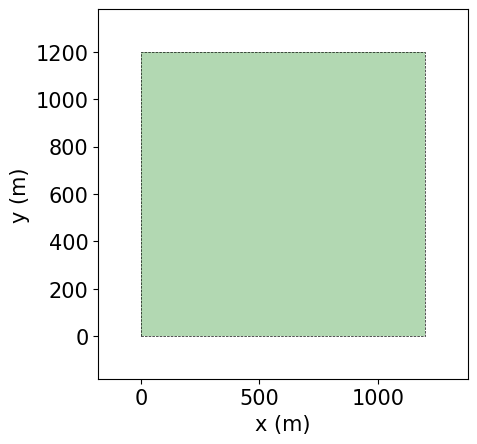

In [56]:
site.plot()

In [57]:
layout = create_layout(site, N_TURBS)

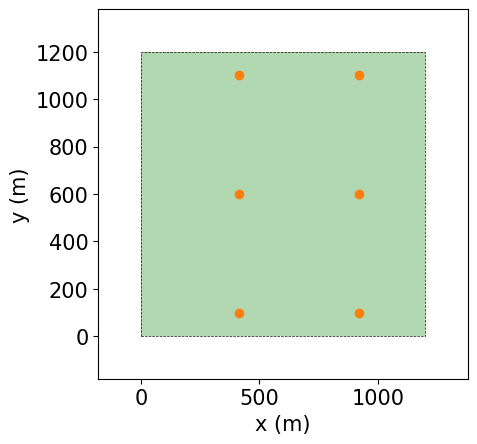

In [58]:
plot_layout(site, layout)

## Run Opt

In [59]:
opt, opt_prob = setup_opt(layout)

In [60]:
print(opt_prob)



Optimization Problem -- Wind Farm Layout Problem
    Objective Function: objective


   Objectives
      Index  Name            Value
          0  obj     0.000000E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name         Type      Lower Bound            Value      Upper Bound     Status
          0  x_coords_0      c     0.000000E+00     4.149437E+02     1.200000E+03           
          1  x_coords_1      c     0.000000E+00     9.189437E+02     1.200000E+03           
          2  x_coords_2      c     0.000000E+00     4.149437E+02     1.200000E+03           
          3  x_coords_3      c     0.000000E+00     9.189437E+02     1.200000E+03           
          4  x_coords_4      c     0.000000E+00     4.149437E+02     1.200000E+03           
          5  x_coords_5      c     0.000000E+00     9.189437E+02     1.200000E+03           
          6  y_coords_0      c     0.000000E+00     9.600000E+01     1.200000E+03           
          7  y_coords_1     

In [61]:
if os.path.exists("./SNOPT_print.out"):
    os.remove("./SNOPT_print.out")

if os.path.exists("./SNOPT_summary.out"):
    os.remove("./SNOPT_summary.out")

In [ ]:
sol = opt(opt_prob, sens="FD")

FLORIS is the system model...
x:  [414.94372512 918.94372512 414.94372512 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073644.23976208
FLORIS is the system model...
x:  [414.94372612 918.94372512 414.94372512 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073663.95948447
FLORIS is the system model...
x:  [414.94372512 918.94372612 414.94372512 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073626.77020955
FLORIS is the system model...
x:  [414.94372512 918.94372512 414.94372612 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073634.86222312
FLORIS is the system model...
x:  [414.94372512 

x:  [415.12001559 918.3651344  413.70073719 918.36559267 413.70073619
 916.94585581]
y:  [  95.9338501    95.71242622  599.17897037  599.99954764 1103.24557129
 1104.28757378]
Simulating wind farm output in FLORIS...
Wind annual energy:  100087083.8676545
FLORIS is the system model...
x:  [415.12001559 918.3651344  413.70073619 918.36559367 413.70073619
 916.94585581]
y:  [  95.9338501    95.71242622  599.17897037  599.99954764 1103.24557129
 1104.28757378]
Simulating wind farm output in FLORIS...
Wind annual energy:  100087089.09981869
FLORIS is the system model...
x:  [415.12001559 918.3651344  413.70073619 918.36559267 413.70073719
 916.94585581]
y:  [  95.9338501    95.71242622  599.17897037  599.99954764 1103.24557129
 1104.28757378]
Simulating wind farm output in FLORIS...
Wind annual energy:  100087102.43386993
FLORIS is the system model...
x:  [415.12001559 918.3651344  413.70073619 918.36559267 413.70073619
 916.94585681]
y:  [  95.9338501    95.71242622  599.17897037  599.999

Wind annual energy:  100089234.0996147
FLORIS is the system model...
x:  [415.68990837 919.27994618 414.26868053 919.27998522 414.26868053
 917.85871941]
y:  [  95.86268664   95.84382393  599.45272457  600.47729485 1103.11274308
 1104.15617607]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089229.85930605
FLORIS is the system model...


## Analysis

In [ ]:
print(sol)